In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [5]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')
#dataset = Dataset.from_pickle(INPUT_PATH)

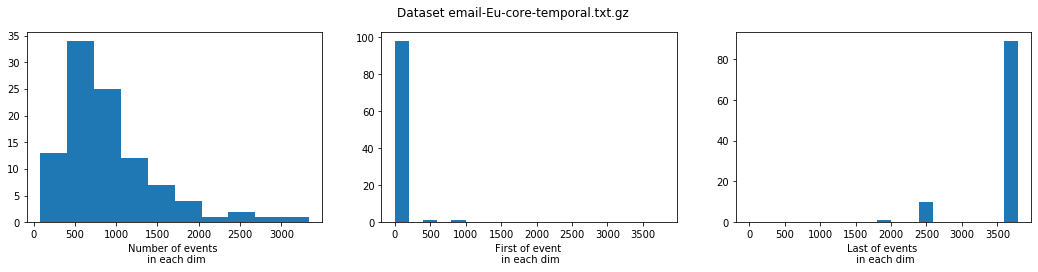

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


Build ground truth adjacency matrix

In [8]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

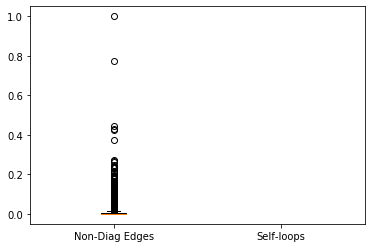

In [9]:
diag_mask = np.eye(len(adjacency_true)).astype(bool)
plt.boxplot([adjacency_true[~diag_mask & (adjacency_true > 0)], adjacency_true[diag_mask & (adjacency_true > 0)]],
            labels=['Non-Diag Edges', 'Self-loops']);

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047905
std        1.697729
min        0.027075
25%        0.290726
50%        0.556137
75%        0.916652
max       13.946247
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean         1.218551
std          2.322353
min          0.000000
25%          0.344177
50%          1.005101
75%          1.474181
max        118.583466
dtype: float64



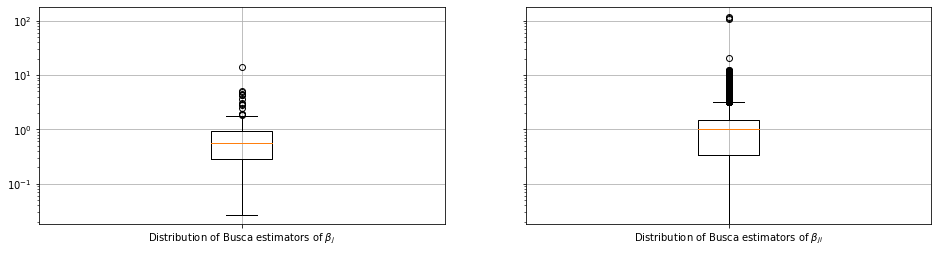

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

In [11]:
events = dataset.timestamps
events = [np.sort(ev) for ev in events]
end_time = dataset.end_time

In [73]:
t0 = min(map(min, events))
t1 = max(map(max, events))

train_start = t0
train_end = t0 + (t1 - t0) * 0.5
test_end = t1 + 1e-5

train_events = [ev[(ev >= train_start) & (ev < train_end)] - train_start for ev in events]
test_events = [ev[(ev >= train_end) & (ev < test_end)] - train_end for ev in events]

print(sum(map(len, train_events)), sum(map(len, test_events)))

69911 23013


In [74]:
69911 / (69911 + 23013)

0.7523460031853988

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    -2.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim:dim+dim**2]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=100,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()]);

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.05)

---

### Run VI

In [75]:
dim = len(train_events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 101.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
1.0
variance
0.010101010101010102


In [81]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariationalOther(verbose=True)
vi_model.observe(events)

In [82]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=40, tol=1e-5, callback=callback)

iter:     1 | dx: +1.0000e-01 | f1-score: 0.00 | relerr: 9.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.35e+00     
iter:     2 | dx: +1.9583e-02 | f1-score: 0.00 | relerr: 1.02e+01 | p@5: 0.20 | p@10: 0.40 | p@20: 0.25 | time/it: 9.93e-01     
iter:     3 | dx: +3.6484e-02 | f1-score: 0.00 | relerr: 1.01e+01 | p@5: 0.20 | p@10: 0.20 | p@20: 0.25 | time/it: 7.93e-01     
iter:     4 | dx: +6.2958e-02 | f1-score: 0.00 | relerr: 1.02e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 8.33e-01     
iter:     5 | dx: +8.7917e-02 | f1-score: 0.00 | relerr: 1.02e+01 | p@5: 0.40 | p@10: 0.20 | p@20: 0.30 | time/it: 9.57e-01     
iter:     6 | dx: +9.9018e-02 | f1-score: 0.00 | relerr: 1.02e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.25 | time/it: 1.01e+00     
iter:     7 | dx: +9.1646e-02 | f1-score: 0.00 | relerr: 1.02e+01 | p@5: 0.40 | p@10: 0.30 | p@20: 0.35 | time/it: 8.33e-01     
iter:     8 | dx: +7.2184e-02 | f1-score: 0.01 | relerr: 1.02e+01 | p@5: 0.40 | p@10: 0.30 | p@20

False

In [230]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
#adj_hat = (vi_model._as_po[1:, :] >= 1) * (vi_model._as_po[1:, :] - 1) / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1
model_name = type(vi_model).__name__

#adj_hat = adj_hat
adj_hat = adj_hat #/ beta_hat

#diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
#adjacency_true_zero_diag = adjacency_true.copy()
#adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.0)


========== Method: WoldModelVariationalOther

Accuracy: 0.26

Edge counts
------------
Pred: 10000.00
True: 2623.00

Error counts
------------
 True Positive: 2623.00
False Positive: 7377.00
 True Negative: 0.00
False Negative: 0.00

Error rates
-----------
 True Positive Rate: 1.00
False Positive Rate: 1.00
 True Negative Rate: 0.00
False Negative Rate: 0.00

F-Score
-------
 F1-Score: 0.42
Precision: 0.26
   Recall: 1.00

Precision@k
-----------
 Prec@10: 0.30
 Prec@50: 0.36
Prec@200: 0.30

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.07474747474747478
10 0.13131313131313116
20 0.2257575757575758
50 0.29050505050505043
100 0.26494949494949493
200 0.13247474747474747



In [224]:
test_dims = np.array([len(ev) > 0 for ev in test_events])
num_test_events = sum(map(len, test_events))
test_events_filtered = np.array(test_events)[test_dims].tolist()
test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events_filtered)

def compute_vi_log_likelihoods(vi_model, num_samples=10):
    vals = list()
    adj_list = list()
    for i in range(num_samples):
        as_po = vi_model._as_po[np.hstack([[True], test_dims]), :][:, test_dims]
        ar_po = vi_model._ar_po[np.hstack([[True], test_dims]), :][:, test_dims]
        bs_po = vi_model._bs_po[test_dims, :][:, test_dims]
        br_po = vi_model._br_po[test_dims, :][:, test_dims]

        alpha_sample = np.random.gamma(shape=as_po, scale=1/ar_po)
        beta_sample = np.random.gamma(shape=bs_po, scale=1/br_po)
        coeffs = torch.tensor(np.hstack((
            alpha_sample[0, :].flatten(), beta_sample.flatten(), alpha_sample[1:, :].flatten()
        )))
        ll = test_model.log_likelihood(coeffs) / num_test_events
        vals.append(ll)
        adj_list.append(np.random.gamma(shape=vi_model._as_po, scale=1/vi_model._ar_po)[1:, :])
    print(f"{np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")
    return vals, adj_list

In [225]:
vals, vi_adj_list = compute_vi_log_likelihoods(vi_model, num_samples=10)

-2.47 ($\pm 2.38e-03$)


In [232]:
[tsvar.utils.metrics.fscore(
    ~np.isclose(vi_adj_list[i], 0).flatten(), 
    (adjacency_true > 0).flatten(), 
    threshold=0.0) 
 for i in range(10)]

[0.3905040786446351,
 0.38653886226297146,
 0.38513443371742967,
 0.3847758081334724,
 0.37588800668616795,
 0.3930926216640502,
 0.38645626502246844,
 0.3869153036774664,
 0.38994764397905757,
 0.388848434411734]

In [227]:
vi_adj_mode = (vi_model._as_po[1:, :] > 1) * (vi_model._as_po[1:, :] - 1) / vi_model._ar_po[1:, :]
vi_adj_mode

array([[-0.00, -0.00,  0.08, ..., -0.00, -0.00, -0.00],
       [ 0.09, -0.00,  0.04, ..., -0.00, -0.00, -0.00],
       [-0.00, -0.00,  0.17, ..., -0.00, -0.00, -0.00],
       ...,
       [-0.00, -0.00, -0.00, ...,  0.05, -0.00, -0.00],
       [ 0.06,  0.03,  0.00, ..., -0.00,  0.02,  0.00],
       [-0.00,  0.04, -0.00, ..., -0.00, -0.00,  0.77]])

In [228]:
import sklearn.metrics
sklearn.metrics.f1_score((adjacency_true>0).flatten(), ~np.isclose(vi_adj_mode, 0).flatten())

0.21783662253310018

In [229]:
import sklearn.metrics
sklearn.metrics.f1_score((adjacency_true>0).flatten(), ~np.isclose(vi_adj_list[0], 0).flatten())

0.3905040786446351

---

### Run GB

In [25]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [34]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))
model_name = type(granger_model).__name__

adj_hat = adj_hat / beta_hat  # Does not matter

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.26

Edge counts
------------
Pred: 508.00
True: 2623.00

Error counts
------------
 True Positive: 167.00
False Positive: 341.00
 True Negative: 7036.00
False Negative: 2456.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.05
 True Negative Rate: 0.95
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.11
Precision: 0.33
   Recall: 0.06

Precision@k
-----------
  Prec@5: 0.00
 Prec@10: 0.00
 Prec@20: 0.05
 Prec@50: 0.04
Prec@100: 0.04
Prec@200: 0.32

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.24848484848484825
10 0.26363636363636367
20 0.19848484848484846
50 0.09898989898989896
100 0.049797979797979786
200 0.024898989898989893



In [102]:
import gb

test_dims = np.array([len(ev) > 0 for ev in test_events])
num_test_events = sum(map(len, test_events))
test_events_filtered = np.array(test_events)[test_dims].tolist()
test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events_filtered)

def compute_gb_log_likelihoods(num_samples=10):
    vals = list()
    for i in range(num_samples):
        print(f'\r{i}', end='')
        # Define model
        granger_model = gb.GrangerBusca(
            alpha_prior=1.0/100,
            num_iter=300,
            metropolis=True,
            beta_strategy='busca',
            num_jobs=10,
        )

        # Fit the model
        granger_model.fit(events)

        # Extract estimate of parameters
        mu_hat = granger_model.mu_[test_dims]
        adj_hat = granger_model.Alpha_.toarray()[test_dims, :][:, test_dims]
        adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
        dim = len(events)
        beta_hat = np.ones((dim, dim)) * granger_model.beta_
        beta_hat = beta_hat[test_dims, :][:, test_dims]
        coeffs_hat = torch.tensor(np.hstack((
            mu_hat, beta_hat.flatten(), adj_hat.flatten()
        )))
        
        ll = test_model.log_likelihood(coeffs_hat) / num_test_events
        vals.append(ll)
    print('\r', end='')
    print(f"{np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")
    return vals

In [103]:
compute_gb_log_likelihoods()

-4.54, ($\pm 3.28e-02$)


[tensor(-4.6080, dtype=torch.float64),
 tensor(-4.5009, dtype=torch.float64),
 tensor(-4.5189, dtype=torch.float64),
 tensor(-4.5211, dtype=torch.float64),
 tensor(-4.5866, dtype=torch.float64),
 tensor(-4.5554, dtype=torch.float64),
 tensor(-4.5309, dtype=torch.float64),
 tensor(-4.5585, dtype=torch.float64),
 tensor(-4.5102, dtype=torch.float64),
 tensor(-4.5570, dtype=torch.float64)]